# Data Loading Examples
## Import packages
- Calibration code is being developed as a python package that can import any necessary class or function.
    - Called "hallprobecalib"
    - Once installed, can be used in any instance of python on that computer
    - may add to PyPI (Python Package Index) for installation via 'pip'

### Install
<https://github.com/ckampa13/hallprobecalib>
- clone repository
- `hallprobecalib/hallprobecalib/__init__.py`, line 3: set proper "hpc_ext_path" (hall probe calibration external data path)
e.g. I use ~/Coding/hallprobecalib_extras/
    - split data directory into 'datafiles' (raw, pickled) and 'plots'
- in terminal, navigate to `hallprobecalib` (base repository directory) and install:
    
    ### **`pip install -e .`**

**Disclaimer:** I have not gone through the necessary steps to make sure package dependancies are installed when installing hallprobecalib. First runtime errors will likely be missing packages (install with pip, conda, etc). Will work this out eventually.

In [31]:
from sys import getsizeof
%matplotlib notebook
#%matplotlib ipympl
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from hallprobecalib.rawdataframe import RawDataFrame
from hallprobecalib.scatter3d import Scatter3d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
plt.rcParams['figure.figsize'] = (6.0, 4.0)

## Raw Data
- Read data from LabView output (.log file).
    - Read line by line
    - Group by grid point (measurement #)
    - Split each grid point into corresponding columns
    - Convert to Pandas DataFrame (a powerful Python data structure)
    - Add new columns for calculated values (mean NMR B, etc)
    - Delete unneeded values (can pick and choose in function call)
    - Serialize data

In [33]:
%time df,meta = RawDataFrame('datafiles/2018-10-03 125726',makepickle=True)
#%time df,meta = RawDataFrame('datafiles/2018-10-09 113712',makepickle=True)
# note this dataframe is already cleaned...not the actual size of the full dataset
print(f"DataFrame Size: {getsizeof(df)/1000/1000} MB") 

CPU times: user 8.96 s, sys: 564 ms, total: 9.52 s
Wall time: 8.92 s
DataFrame Size: 14.120424000000002 MB


## Serialized Data
- Once the raw data is cleaned and saved in a serialized format ('pickling'), the resulting data file is reduced in size and can be read in significantly faster.

In [5]:
%time df,meta = RawDataFrame('datafiles/2018-10-03 125726',frompickle=True)
#%time df,meta = RawDataFrame('datafiles/2018-10-09 113712',frompickle=True)
print(f"\n{df.columns}\nNumber of Measurements: {len(df)}")
print(f"DataFrame Size: {getsizeof(df)/1000/1000} MB") 

CPU times: user 54.2 ms, sys: 11.6 ms, total: 65.7 ms
Wall time: 81 ms

Index(['PS_DMM', 'X_ZAB', 'Y_ZAB', 'Z_ZAB', 'X', 'Y', 'Z', 'PAT_X', 'PAT_Y',
       'PAT_Z', 'BX_CAL_1', 'BY_CAL_1', 'BZ_CAL_1', 'BX_CAL_2', 'BY_CAL_2',
       'BZ_CAL_2', 'BX_RAW_1', 'BY_RAW_1', 'BZ_RAW_1', 'BX_RAW_2', 'BY_RAW_2',
       'BZ_RAW_2', 'B_MAG_CAL_1', 'B_MAG_CAL_2', 'NMR_B_AVG', 'FFT_MAX',
       'TEMP_1', 'TEMP_2', 'GRAD_B_X', 'GRAD_B_Y', 'GRAD_B_Z', 'GRAD_B_MAG'],
      dtype='object')
Number of Measurements: 35301
DataFrame Size: 14.120424000000002 MB


## File Size Reduction and Loading Speed Improvement:
35,301 measurements:
- Raw: 211.8 MB, ~8 s
- Pickled: 11.5 MB, ~75 ms

## Memory Usage
- significant improvements for pickled data

**Raw Data**
![raw](plots/data_load_mem_test_raw.png)

**Pickled Data**
![pickled](plots/data_load_mem_test_pickled.png)

# **Takeaways**
- Serializing data greatly improves speed of data loading and decreases file size
- Will need to make concrete estimates of expected data quantities.

**Q: Is the current method good enough?**

A: Probably. My estimate for 1,000,000 measurements: 6 GB raw (~4 min to load, pickling), 325.8 MB pickled (~1.5 s to load).

# Immediate Usability: Analyze & Plot
The DataFrame on its own can be manipulated easily interactively, or can be used for more complex analyses in scripts and modules.

### Example 1: Histogram of NMR B readings for all grid points

<IPython.core.display.Javascript object>


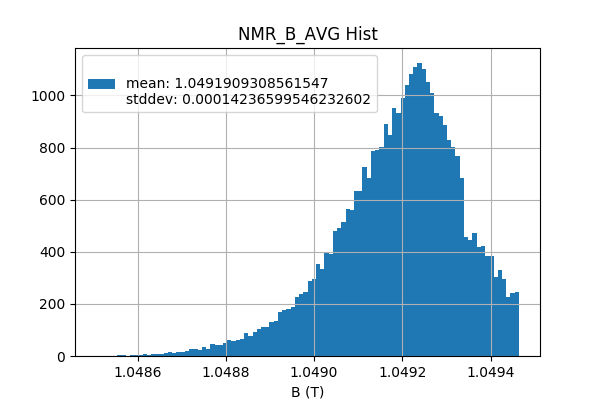

In [6]:
_ = plt.figure()
df.NMR_B_AVG.hist(bins=100,label=f"\nmean: {df.NMR_B_AVG.mean()}\nstddev: {df.NMR_B_AVG.std()}")

plt.title("NMR_B_AVG Hist")
plt.xlabel("B (T)")
plt.legend();

### Example 2: Histogram of NMR Resonance Peak Height (FFT Peak)

<IPython.core.display.Javascript object>


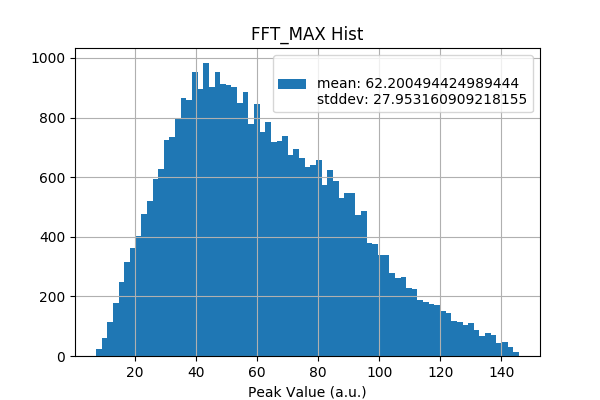

In [7]:
_ = plt.figure()
df.FFT_MAX.hist(bins=75,label=f"\nmean: {df.FFT_MAX.mean()}\nstddev: {df.FFT_MAX.std()}")

plt.title("FFT_MAX Hist")
plt.xlabel("Peak Value (a.u.)")
plt.legend();

### Example 3: Temperature vs. Measurement # (f vs. t)

In [8]:
# cut out bad measurements
t1 = df.TEMP_1 != 0
t2 = df.TEMP_2 != 0

<IPython.core.display.Javascript object>


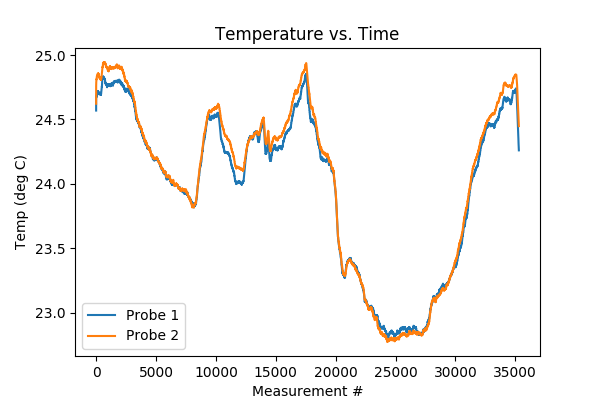

In [9]:
_ = plt.figure()
df[t1].TEMP_1.plot(label=f"Probe 1")
df[t2].TEMP_2.plot(label=f"Probe 2")

plt.title("Temperature vs. Time")
plt.xlabel("Measurement #")
plt.ylabel("Temp (deg C)")
plt.legend();

### Example 4: 3D scatter plot with gradient cut
- Uses pandas filtering and imported hallprobecalib plotting function "Scatter3d"
- Cut data based on magnitude of the gradient of B
- Plot the B values of the cut data
- Visual x cut

<IPython.core.display.Javascript object>


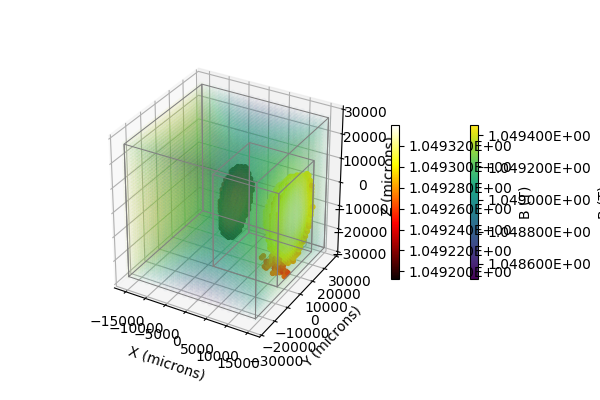

In [10]:
fig,ax = Scatter3d(df.X,df.Y,df.Z,df.NMR_B_AVG,colorsMap='viridis',alpha=0.025,psize=10)
g_cut = df.GRAD_B_MAG < df.GRAD_B_MAG.quantile(0.05)
fig,ax = Scatter3d(df[g_cut].X,df[g_cut].Y,df[g_cut].Z,df[g_cut].NMR_B_AVG,
                   colorsMap='hot',alpha=1.,psize=10,fig=fig,ax=ax)

<IPython.core.display.Javascript object>


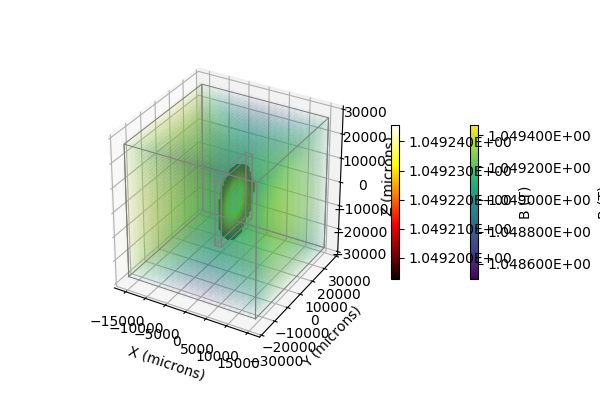

In [11]:
x0 = df.X < 7500
fig,ax = Scatter3d(df.X,df.Y,df.Z,df.NMR_B_AVG,colorsMap='viridis',alpha=0.025,psize=10)
fig,ax = Scatter3d(df[g_cut&x0].X,df[g_cut&x0].Y,df[g_cut&x0].Z,df[g_cut&x0].NMR_B_AVG,
                   colorsMap='hot',alpha=1.,psize=10,fig=fig,ax=ax)

<IPython.core.display.Javascript object>


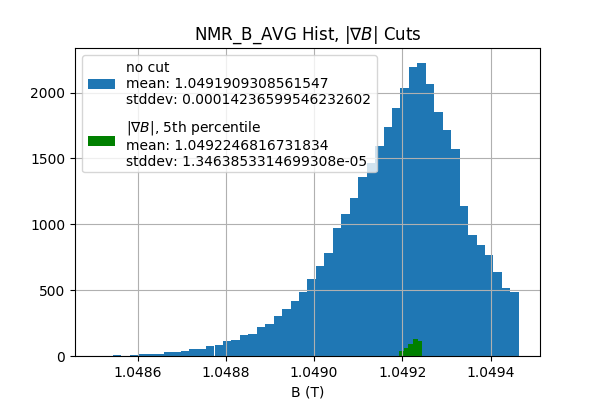

In [12]:
_ = plt.figure()
df.NMR_B_AVG.hist(bins=50, label=r"no cut"+f"\nmean: {df.NMR_B_AVG.mean()}\nstddev: {df.NMR_B_AVG.std()}")
df[g_cut&x0].NMR_B_AVG.hist(bins=5, color='green',label=r"$|\nabla B|$, 5th percentile"+f"\nmean: {df[g_cut&x0].NMR_B_AVG.mean()}\nstddev: {df[g_cut&x0].NMR_B_AVG.std()}")

plt.title(r"NMR_B_AVG Hist, $|\nabla B|$ Cuts")
plt.xlabel("B (T)")
plt.legend();

<IPython.core.display.Javascript object>


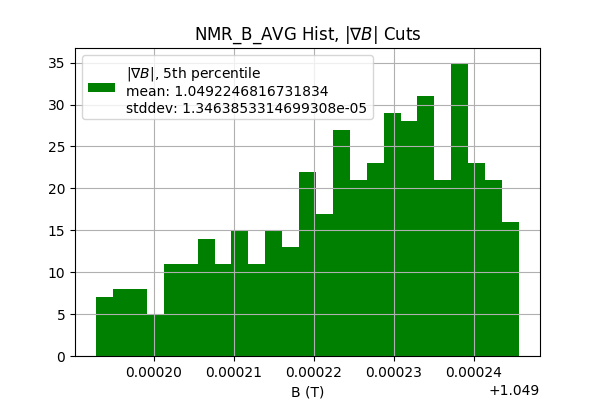

In [13]:
_ = plt.figure()
df[g_cut&x0].NMR_B_AVG.hist(bins=25, color='green', label=r"$|\nabla B|$, 5th percentile"+f"\nmean: {df[g_cut&x0].NMR_B_AVG.mean()}\nstddev: {df[g_cut&x0].NMR_B_AVG.std()}")

plt.title(r"NMR_B_AVG Hist, $|\nabla B|$ Cuts")
plt.xlabel("B (T)")
plt.legend();

In [139]:
#plt.close("all")

In [14]:
# number of points in dataset, number of points after cut
len(df), len(df[g_cut&x0])

(35301, 443)

In [15]:
# range of B (T) all data
df.NMR_B_AVG.max()-df.NMR_B_AVG.min()

0.0009582432599997137

In [16]:
# range of B (T) after cut 
df[g_cut&x0].NMR_B_AVG.max()-df[g_cut&x0].NMR_B_AVG.min()

5.286699999973443e-05

- wrote script to find minimum range for n points within the entire dataset
- probably not useful, just interesting to see how close we get
min_b_range yields: 3.4769e-6 T (5 percentile gradient), 9.8187e-6 T (10 percentile gradient)

# Integrating Plotly
- Plotly produces beautiful interactive plots in 2D and 3D
- html is the native output, which makes embedding an interactive plot simple
- saved plot is still interactive
- html is ubiquitous...can view on any (??) system (e.g. and iPhone)

In [17]:
import numpy as np
import pandas as pd

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

## Easy Function Calls

In [18]:
# full dataset
trace1 = go.Scatter3d(
    x=df.X,
    y=df.Y,
    z=df.Z,
    mode='markers',
    marker=dict(
        size=2,
        color=df.GRAD_B_MAG,                # set color to an array/list of desired values
        colorscale='Hot',   # choose a colorscale
        opacity=0.2
    )
)
# dataset with gradient and x cuts
trace2 = go.Scatter3d(
    x=df[g_cut&x0].X,
    y=df[g_cut&x0].Y,
    z=df[g_cut&x0].Z,
    mode='markers',
    marker=dict(
        size=2,
        color=df[g_cut&x0].GRAD_B_MAG,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1.
    )
)

In [19]:
# gather data and setup plot frame parameters
data = [trace1,trace2]

layout = go.Layout(
    title='NMR B with/without Grad B Cut',
    autosize=False,
    width=600,
    height=600,
    margin=dict(l=0,r=0,b=0,t=0)
)
fig2 = go.Figure(data=data, layout=layout)

In [20]:
# plot!
iplot(fig2, filename='3d-scatter-colorscale-NMR-B')

In [21]:
# plot only data with cuts
fig3 = go.Figure(data=[trace2], layout=layout)
iplot(fig3, filename="3d-scatter-NMR_B_AVG_cuts_only")

# Magnetic Field for Low Gradient: X Slice

In [22]:
x_cut = df.X == 0.
x = df[x_cut].Y.unique()
y = df[x_cut].Z.unique()
z = np.array(df[x_cut].GRAD_B_MAG.abs())

g_max = df[x_cut].GRAD_B_MAG.quantile(0.05)

z = [i if i<=g_max else g_max for i in z]

In [23]:
xx,yy= np.meshgrid(x,y)
zz = np.reshape(z,(len(x),len(y)))

In [24]:
# define plot data
data = [go.Surface(x=xx,y=yy,z=zz, colorscale="Viridis")]
# plot params
layout = go.Layout(
    title='Grad B Magnitude',
    autosize=False,
    width=600,
    height=600,
    margin=dict(l=0,r=0,b=0,t=0)
)
# define figure
fig = go.Figure(data=data, layout=layout)

In [25]:
iplot(fig, filename='gradient_test.html')

## Plot Magnetic Field of Cut Data

In [26]:
g_cut_slice = df[x_cut].GRAD_B_MAG < df[x_cut].GRAD_B_MAG.quantile(0.05)


In [27]:
trace = go.Scatter3d(
    x=df[g_cut_slice&x_cut].X,
    y=df[g_cut_slice&x_cut].Y,
    z=df[g_cut_slice&x_cut].Z,
    mode='markers',
    marker=dict(
        size=2,
        color=df[g_cut_slice&x_cut].NMR_B_AVG,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1.
    )
)

data = [trace]

layout = go.Layout(
    autosize=False,
    width=600,
    height=600,
    margin=dict(l=0,r=0,b=0,t=0)
)
fig = go.Figure(data=data, layout=layout)

In [28]:
iplot(fig)

In [29]:
df[g_cut_slice&x_cut].NMR_B_AVG.max()-df[g_cut_slice&x_cut].NMR_B_AVG.min()

1.771861999966262e-05

In [30]:
df[x_cut].NMR_B_AVG.max()-df[x_cut].NMR_B_AVG.min()

0.0006619473599998038

# Conclusions
- A lot of progress has been made
- Code is still rough around the edges and needs some work to get a stable package
- Once data is loaded and cleaned: plotting, analyzing, etc. is reduce to simple function calls and logic for cuts
    -Easy to import functions to do more complex analyses when the time comes

# Discussion: Next Steps

- Should develop a short term plan for code to ensure time is spent well
- I have plenty to do for making sure the code progresses in an orderly way
    - want to avoid tunnel vision with making code improvements

### Ideas Discussed For Data Collection:
- Another fine grid scan in the region of lowest gradient (working on checking if current fine scan is in this region)
- Reproducibility of NMR probe and hall probes
    - Should happen over a long period of time, good to start early and work out the bugs well before real calibration data is collected
    - Could develop validation scripts for scheduled reproducibility tests
- Coefficient of temperature for hall probe(s)